In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from scipy.stats import invwishart
from scipy.linalg import inv

In [2]:
from bml import bayes_ml, not_bayes_ml

## Artificial low-dimensional examples

### S-shape

In [3]:
n_samples = 1500
noise_level = 0.6

# True values
Z, t = make_s_curve(n_samples, 0, random_state=1)

# Add noise
eps = rand(n_samples, 3) - 0.5
Y = Z + noise_level * eps

In [4]:
n_iterations = 19
a = 1.15
bandwidths = 0.6 * a**(-np.arange(n_iterations))
print(bandwidths)

[0.6        0.52173913 0.4536862  0.39450974 0.34305195 0.29830604
 0.25939656 0.22556222 0.19614106 0.17055745 0.14831082 0.12896593
 0.11214429 0.09751677 0.08479719 0.07373669 0.06411886 0.05575553
 0.04848307]


In [5]:
# %%time
X = bayes_ml(Y, Z, bandwidths, tau=0.9)

before first iteration: 0.09122312469630811
iteration 1 : 0.06855213885575531
iteration 2 : 0.08648729237285512
iteration 3 : 0.08649462901716067
iteration 4 : 0.08649437087636612
iteration 5 : 0.08649426123943862
iteration 6 : 0.0864940085674117
iteration 7 : 0.08649393727684326
iteration 8 : 0.08649380515446851
iteration 9 : 0.08649379924289534
iteration 10 : 0.08649392012779558
iteration 11 : 0.086494055678742
iteration 12 : 0.08649421351723387
iteration 13 : 0.08649452896649142
iteration 14 : 0.08649475594185985
iteration 15 : 0.08649487455782132
iteration 16 : 0.08649507812674714
iteration 17 : 0.08649529469657653
iteration 18 : 0.0864954172856453
iteration 19 : 0.08649551927537413


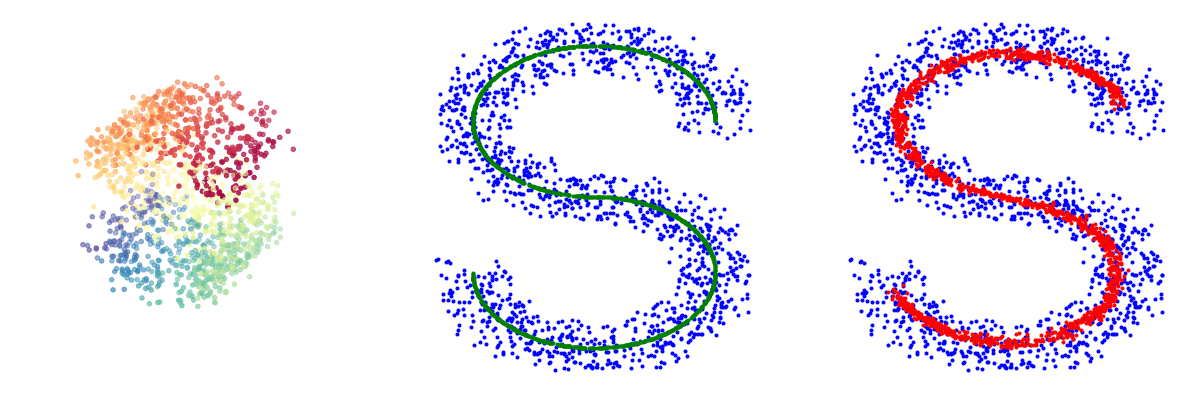

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral, label='Noisy observations')
ax.axis('off')
ax = fig.add_subplot(132)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
ax.axis('off')
ax = fig.add_subplot(133)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 2], 'r.', label='Recovered manifold')
ax.axis('off')
plt.savefig('same_s-shape.png', dpi=500)
plt.show()
plt.close()

### Swiss Roll

In [7]:
n_samples = 1500
noise_level = 2.5

# True values
Z, t = make_swiss_roll(n_samples, 0, random_state=1)

# Add noise
eps = rand(n_samples, 3) - 0.5
Y = Z + noise_level * eps

In [8]:
n_iterations = 10
a = 1.1
bandwidths = 2.5 * a**(-np.arange(n_iterations))
print(bandwidths)

[2.5        2.27272727 2.0661157  1.878287   1.70753364 1.55230331
 1.41118483 1.2828953  1.16626845 1.06024405]


In [9]:
X = bayes_ml(Y, Z, bandwidths, tau=4.0)

before first iteration: 1.5506102572513383
iteration 1 : 1.196447831348275
iteration 2 : 1.4126498393760227
iteration 3 : 1.4165334737280912
iteration 4 : 1.4163700996976831
iteration 5 : 1.4163814500186636
iteration 6 : 1.4165209856869863
iteration 7 : 1.4162742177980132
iteration 8 : 1.4162494668119041
iteration 9 : 1.4161905397979089
iteration 10 : 1.4165128736159116


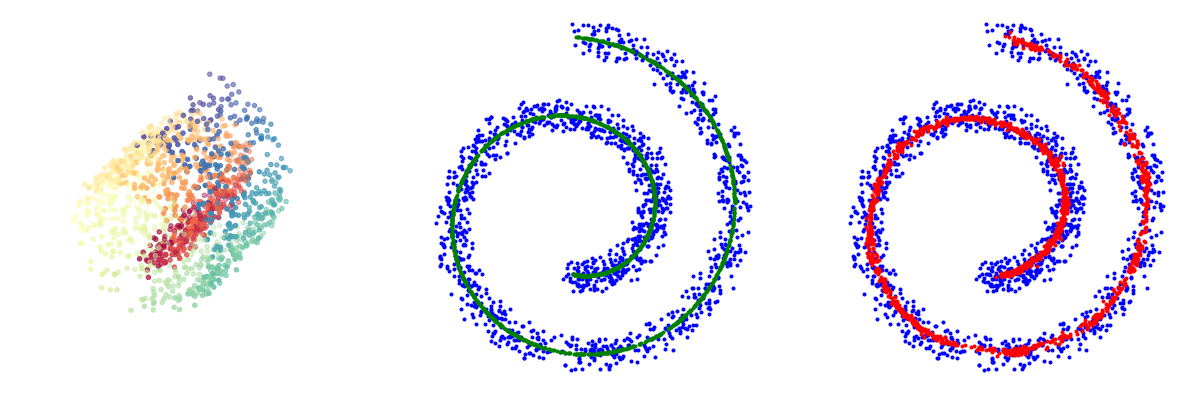

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral, label='Noisy observations')
ax.axis('off')
ax = fig.add_subplot(132)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
ax.axis('off')
ax = fig.add_subplot(133)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 2], 'r.', label='Recovered manifold')
ax.axis('off')
plt.savefig('same_s-shape.png', dpi=500)
plt.show()
plt.close()

### Sphere

In [11]:
n_samples = 1500
total_dim = 3
manifold_dim = 2
noise_level = 0.2

# True values
Z = np.zeros((n_samples, total_dim))
# Z[:,0] = np.random.uniform(-1, 1, (n_samples))
Z[:, :manifold_dim] = np.random.normal(size=(n_samples, manifold_dim))
Z[:, :manifold_dim] /= np.linalg.norm(Z, axis = 1, keepdims=True)

# Add noise
eps = rand(n_samples, total_dim) - 0.5
Y = Z + noise_level * eps

In [12]:
n_iterations = 10
a = 1.1
bandwidths = 0.3 * a**(-np.arange(n_iterations))
print(bandwidths)

[0.3        0.27272727 0.24793388 0.22539444 0.20490404 0.1862764
 0.16934218 0.15394744 0.13995221 0.12722929]


In [13]:
X = bayes_ml(Y, Z, bandwidths, tau=0.4)

before first iteration: 0.010106371640544499
iteration 1 : 0.003803529211315303
iteration 2 : 0.004218925928481554
iteration 3 : 0.00421894292357305
iteration 4 : 0.004218944981727084
iteration 5 : 0.004218944663581402
iteration 6 : 0.004218941819345372
iteration 7 : 0.0042189408375393166
iteration 8 : 0.004218941656063203
iteration 9 : 0.004218942267886458
iteration 10 : 0.004218941777216561


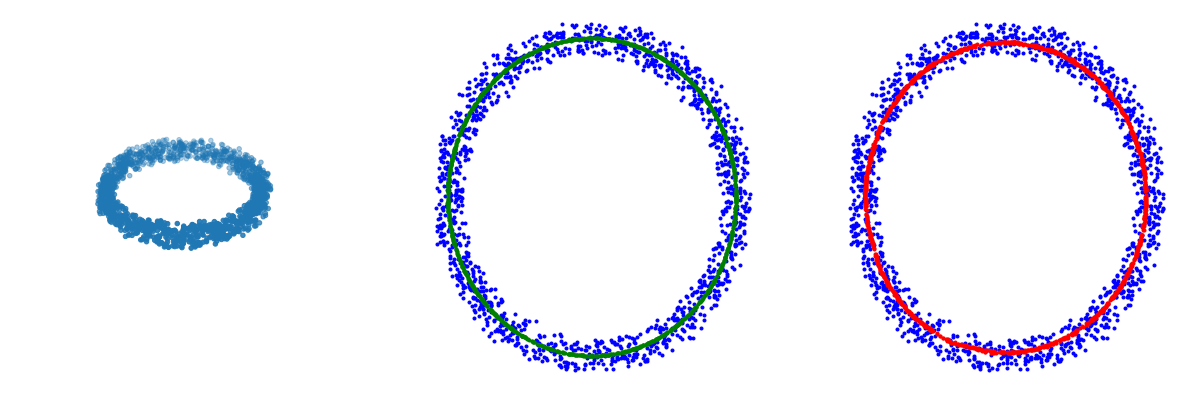

In [14]:
%matplotlib inline
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], cmap=plt.cm.Spectral, label='Noisy observations')
ax.set_zlim(-1,1)
ax.axis('off')
ax = fig.add_subplot(132)
ax.plot(Y[:, 0], Y[:, 1], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 1], 'g.', label='True manifold')
ax.axis('off')
ax = fig.add_subplot(133)
ax.plot(Y[:, 0], Y[:, 1], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 1], 'r.', label='Recovered manifold')
ax.axis('off')
plt.savefig('same_s-shape.png', dpi=500)
plt.show()
plt.close()

In [15]:
X = not_bayes_ml(Y, Z, bandwidths, tau=0.4)

before first iteration: 0.010106371640544499
iteration 1 : 0.003803529211315303
iteration 2 : 0.003969999220086221
iteration 3 : 0.003988217942495999
iteration 4 : 0.00398918611269177
iteration 5 : 0.00399428723132264
iteration 6 : 0.004007659991560475
iteration 7 : 0.004031399909975455
iteration 8 : 0.004067231817063469
iteration 9 : 0.0041165761898283955
iteration 10 : 0.004180401006164676


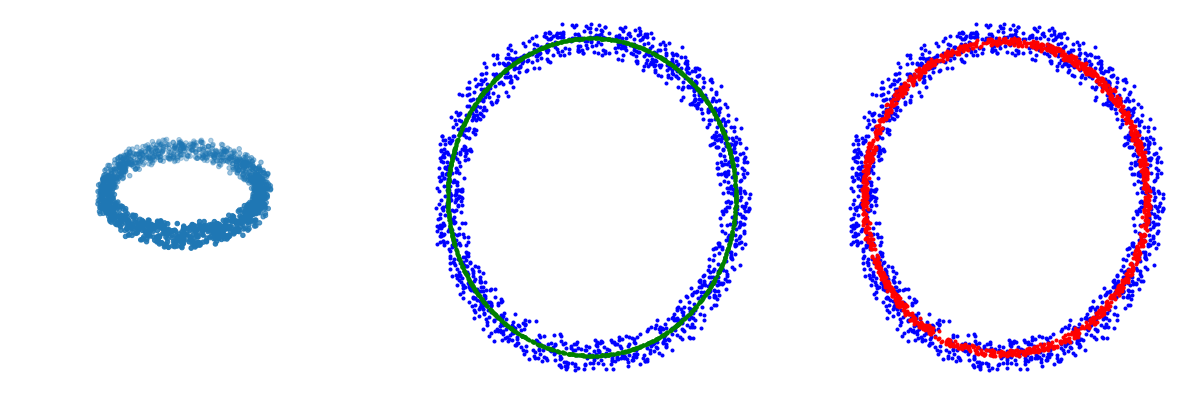

In [16]:
%matplotlib inline
fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], cmap=plt.cm.Spectral, label='Noisy observations')
ax.set_zlim(-1,1)
ax.axis('off')
ax = fig.add_subplot(132)
ax.plot(Y[:, 0], Y[:, 1], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 1], 'g.', label='True manifold')
ax.axis('off')
ax = fig.add_subplot(133)
ax.plot(Y[:, 0], Y[:, 1], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 1], 'r.', label='Recovered manifold')
ax.axis('off')
plt.savefig('same_s-shape.png', dpi=500)
plt.show()
plt.close()